In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

%matplotlib inline

We're ready to build our first neural network. We will have multiple features we feed into our model, each of which will go through a set of perceptron models to arrive at a response which will be trained to our output.

Like many models we've covered, this can be used as both a regression or classification model.

First, we need to load our dataset. For this example we'll use The Museum of Modern Art in New York's [public dataset](https://media.githubusercontent.com/media/MuseumofModernArt/collection/master/Artworks.csv) on their collection.

In [2]:
artworks = pd.read_csv('https://media.githubusercontent.com/media/MuseumofModernArt/collection/master/Artworks.csv')

In [3]:
artworks.columns

Index(['Title', 'Artist', 'ConstituentID', 'ArtistBio', 'Nationality',
       'BeginDate', 'EndDate', 'Gender', 'Date', 'Medium', 'Dimensions',
       'CreditLine', 'AccessionNumber', 'Classification', 'Department',
       'DateAcquired', 'Cataloged', 'ObjectID', 'URL', 'ThumbnailURL',
       'Circumference (cm)', 'Depth (cm)', 'Diameter (cm)', 'Height (cm)',
       'Length (cm)', 'Weight (kg)', 'Width (cm)', 'Seat Height (cm)',
       'Duration (sec.)'],
      dtype='object')

We'll also do a bit of data processing and cleaning, selecting columns of interest and converting URL's to booleans indicating whether they are present.

In [4]:
# Select Columns.
artworks = artworks[['Artist', 'Nationality', 'Gender', 'Date', 'Department',
                    'DateAcquired', 'URL', 'ThumbnailURL', 'Height (cm)', 'Width (cm)']]

# Convert URL's to booleans.
artworks['URL'] = artworks['URL'].notnull()
artworks['ThumbnailURL'] = artworks['ThumbnailURL'].notnull()

# Drop films and some other tricky rows.
artworks = artworks[artworks['Department']!='Film']
artworks = artworks[artworks['Department']!='Media and Performance Art']
artworks = artworks[artworks['Department']!='Fluxus Collection']

# Drop missing data.
artworks = artworks.dropna()

In [5]:
artworks.head()

,Artist,Nationality,Gender,Date,Department,DateAcquired,URL,ThumbnailURL,Height (cm),Width (cm)
0,Otto Wagner,(Austrian),(Male),1896,Architecture & Design,1996-04-09,True,True,48.6000,168.9000
1,Christian de Portzamparc,(French),(Male),1987,Architecture & Design,1995-01-17,True,True,40.6401,29.8451
2,Emil Hoppe,(Austrian),(Male),1903,Architecture & Design,1997-01-15,True,True,34.3000,31.8000
3,Bernard Tschumi,(),(Male),1980,Architecture & Design,1995-01-17,True,True,50.8000,50.8000
4,Emil Hoppe,(Austrian),(Male),1903,Architecture & Design,1997-01-15,True,True,38.4000,19.1000


## Building a Model

Now, let's see if we can use multi-layer perceptron modeling (or "MLP") to see if we can classify the department a piece should go into using everything but the department name.

Before we import MLP from SKLearn and establish the model we first have to ensure correct typing for our data and do some other cleaning.

In [6]:
# Get data types.
artworks.dtypes

Artist           object
Nationality      object
Gender           object
Date             object
Department       object
DateAcquired     object
URL                bool
ThumbnailURL       bool
Height (cm)     float64
Width (cm)      float64
dtype: object

The `DateAcquired` column is an object. Let's transform that to a datetime object and add a feature for just the year the artwork was acquired.

In [7]:
artworks['DateAcquired'] = pd.to_datetime(artworks.DateAcquired)
artworks['YearAcquired'] = artworks.DateAcquired.dt.year
artworks['YearAcquired'].dtype

dtype('int64')

Great. Let's do some more miscellaneous cleaning.

In [8]:
# Remove multiple nationalities, genders, and artists.
artworks.loc[artworks['Gender'].str.contains('\) \('), 'Gender'] = '\(multiple_persons\)'
artworks.loc[artworks['Nationality'].str.contains('\) \('), 'Nationality'] = '\(multiple_nationalities\)'
artworks.loc[artworks['Artist'].str.contains(','), 'Artist'] = 'Multiple_Artists'

# Convert dates to start date, cutting down number of distinct examples.
artworks['Date'] = pd.Series(artworks.Date.str.extract(
    '([0-9]{4})', expand=False))[:-1]

# Final column drops and NA drop.
X = artworks.drop(['Department', 'DateAcquired', 'Artist', 'Nationality', 'Date'], 1)

# Create dummies separately.
artists = pd.get_dummies(artworks.Artist)
nationalities = pd.get_dummies(artworks.Nationality)
dates = pd.get_dummies(artworks.Date)

# Concat with other variables, but artists slows this wayyyyy down so we'll keep it out for now
X = pd.get_dummies(X, sparse=True)
X = pd.concat([X, nationalities, dates], axis=1)

Y = artworks.Department

In [9]:
# Alright! We've done our prep, let's build the model.
# Neural networks are hugely computationally intensive.
# This may take several minutes to run.

# Import the model.
from sklearn.neural_network import MLPClassifier

# Establish and fit the model, with a single, 1000 perceptron layer.
#mlp = MLPClassifier(hidden_layer_sizes=(10,))
#mlp.fit(X, Y)

In [10]:
#mlp.score(X, Y)

In [11]:
Y.value_counts()/len(Y)

Drawings & Prints        0.622507
Photography              0.226466
Architecture & Design    0.112970
Painting & Sculpture     0.033684
Media and Performance    0.004372
Name: Department, dtype: float64

In [12]:
from sklearn.model_selection import cross_val_score
#cross_val_score(mlp, X, Y, cv=5)

Now we got a lot of information from all of this. Firstly we can see that the model seems to overfit, though there is still so remaining performance when validated with cross validation. This is a feature of neural networks that aren't given enough data for the number of features present. _Neural networks, in general, like_ a lot _of data_. You may also have noticed something also about neural networks: _they can take a_ long _time to run_. Try increasing the layer size by adding a zero. Feel free to interrupt the kernel if you don't have time...

Also note that we created bools for artist's name but left them out. Both of the above points are the reason for that. It would take much longer to run and it would be much more prone to overfitting.

## Model parameters

Now, before we move on and let you loose with some tasks to work on the model, let's go over the parameters.

We included one parameter: hidden layer size. Remember in the previous lesson, when we talked about layers in a neural network. This tells us how many and how big to make our layers. Pass in a tuple that specifies each layer's size. Our network is 1000 neurons wide and one layer. (100, 4, ) would create a network with two layers, one 100 wide and the other 4.

How many layers to include is determined by two things: computational resources and cross validation searching for convergence. It's generally less than the number of input variables you have.

You can also set an alpha. Neural networks like this use a regularization parameter that penalizes large coefficients just like we discussed in the advanced regression section. Alpha scales that penalty.

Lastly, we'll discuss the activation function. The activation function determines whether the output from an individual perceptron is binary or continuous. By default this is a 'relu', or 'rectified linear unit function' function. In the exercise we went through earlier we used this binary function, but we discussed the _sigmoid_ as a reasonable alternative. The _sigmoid_ (called 'logistic' by SKLearn because it's a 'logistic sigmoid function') allows for continuous variables between 0 and 1, which allows for a more nuanced model. It does come at the cost of increased computational complexity.

If you want to learn more about these, study [activation functions](https://en.wikipedia.org/wiki/Activation_function) and [multilayer perceptrons](https://en.wikipedia.org/wiki/Multilayer_perceptron). The [Deep Learning](http://www.deeplearningbook.org/) book referenced earlier goes into great detail on the linear algebra involved.

You could also just test the models with cross validation. Unless neural networks are your specialty cross validation should be sufficient.

For the other parameters and their defaults, check out the [MLPClassifier documentation](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier).

## Drill: Playing with layers

Now it's your turn. Using the space below, experiment with different hidden layer structures. You can try this on a subset of the data to improve runtime. See how things vary. See what seems to matter the most. Feel free to manipulate other parameters as well. It may also be beneficial to do some real feature selection work...

In order for the model to run at a decent speed I am going to take a very small sample of the feature set dto play with.

In [13]:
len(artworks.sample(frac=.0098))

1062

In [14]:
# take sample of dataset 
artwork = artworks.sample(frac=.0098,random_state=20)



# Final column drops and NA drop.
X = artwork.drop(['Department', 'DateAcquired', 'Artist', 'Nationality', 'Date'], 1)

# Create dummies separately.
artists = pd.get_dummies(artwork.Artist)
nationalities = pd.get_dummies(artwork.Nationality)
dates = pd.get_dummies(artwork.Date)

# Concat with other variables, but artists slows this wayyyyy down so we'll keep it out for now
X = pd.get_dummies(X, sparse=True)
X = pd.concat([X, nationalities, dates, artists], axis=1)

Y = artwork.Department

In [15]:
X.shape

(1062, 821)

In [16]:
Y.shape

(1062,)

Here I have added the artists artists one hot encoded features and then below I will select the 100 best features from all the included features.

In [17]:
# Select 100 best features
import sklearn.feature_selection 
select =sklearn.feature_selection.SelectKBest(k=100)
selected_features = select.fit(X, Y)
indicies_selected = selected_features.get_support(indices=True)
colnames_selected = [X.columns[i] for i in indicies_selected]
print(colnames_selected)
#X = X[colnames_selected] 

['URL', 'ThumbnailURL', 'Height (cm)', 'Width (cm)', 'YearAcquired', 'Gender_()', 'Gender_(Female)', 'Gender_(Male)', 'Gender_\\(multiple_persons\\)', '()', '(American)', '(Argentine)', '(Belgian)', '(Danish)', '(French)', '(Guatemalan)', '(Indian)', '(Nationality Unknown)', '(Spanish)', '(Swiss)', '\\(multiple_nationalities\\)', '1871', '1929', '1932', '1938', '1954', '1955', '1962', '1963', '1964', '1974', '1978', '1981', '1991', '1999', '2015', '2017', 'Al Held', 'Aleksandr Archipenko', 'Alvin Lustig', 'Andrea Zittel', 'Antoni Tàpies', 'Barnett Newman', 'Carolee Schneemann', 'Craig Kauffman', 'Daniel Grataloup', 'Dorothea Lange', 'Dorothea Rockburne', 'Eduardo Costa', 'Edward Steichen', 'Edward Weston', 'El Lissitzky', 'Eugène Atget', 'Fernand Léger', 'Francis Alÿs', 'Franz Erhard Walther', 'Franz West', 'George McNeil', 'George Segal', 'Isamu Noguchi', 'Jacob Lawrence', 'Jan Dibbets', 'Jan Tschichold', 'Jean Charlot', 'Jerome Neuner', 'Joel Shapiro', 'John Day', 'John Kane', 'John 

In [18]:
features = X.columns.values[select.get_support()]
scores = select.scores_[select.get_support()]
features_scores = list(zip(features, scores))
feat_scores_df = pd.DataFrame(data = features_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
sorted_features = feat_scores_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(sorted_features[:50])

                     Feat_names    F_Scores
88                       Pope.L  131.378531
2                   Height (cm)  105.274986
3                    Width (cm)   59.287075
36                         2017   52.551412
43           Carolee Schneemann   52.551412
54                 Francis Alÿs   52.551412
72                   Lea Lublin   52.551412
80                 Martine Syms   52.551412
76     Ludwig Mies van der Rohe   27.719305
95         Unknown photographer   16.970183
83             Multiple_Artists   16.862045
4                  YearAcquired   15.854604
0                           URL   15.718471
73              Lee Friedlander   12.961211
14                     (French)   12.602743
8   Gender_\(multiple_persons\)   11.981882
20   \(multiple_nationalities\)   11.981882
5                     Gender_()   10.713071
19                      (Swiss)   10.192578
10                   (American)    9.402929
11                  (Argentine)    8.307704
7                 Gender_(Male) 

In [19]:
X = X[colnames_selected] 

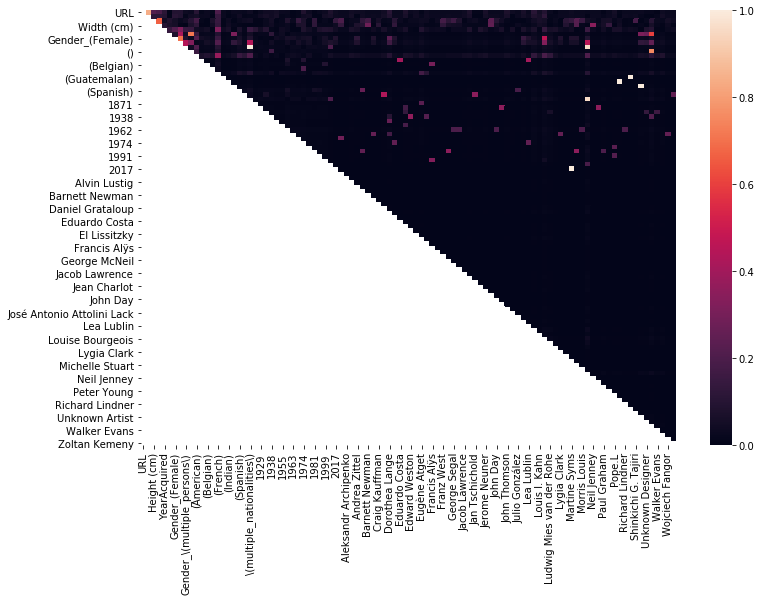

In [20]:
corr_matrix = X.corr().abs().where(np.triu(np.ones(X.corr().abs().shape), k=1).astype(np.bool))
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix,annot=False)
plt.show()

In [21]:
to_drop = [column for column in corr_matrix.columns if any(corr_matrix[column] > 0.50)]
print('Columns to drop: ' , (len(to_drop)))
to_drop

Columns to drop:  11


['ThumbnailURL',
 'Width (cm)',
 'Gender_(Male)',
 '()',
 '\\(multiple_nationalities\\)',
 'Martine Syms',
 'Multiple_Artists',
 'Raj Rewal',
 'Roberto González Goyri',
 'Unknown Artist',
 'Unknown photographer']

In [22]:
# Drop one of each pair of correlated features
X.drop(to_drop,1,inplace=True)
 

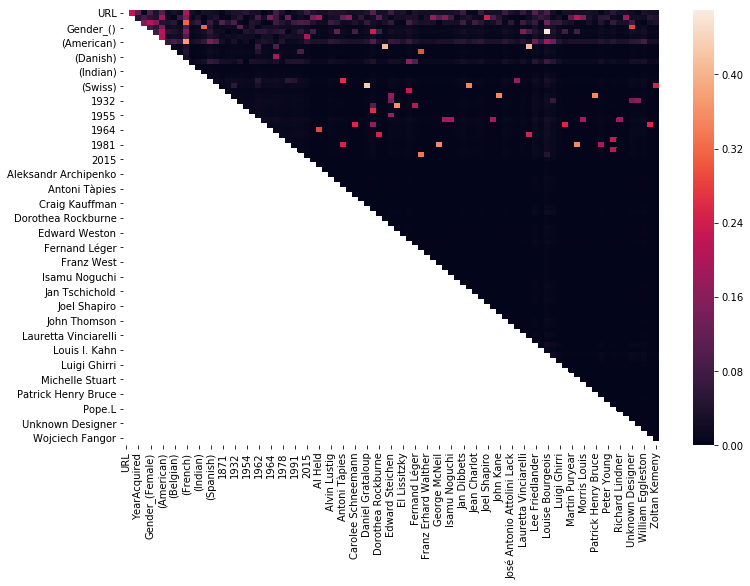

In [23]:
corr_matrix = X.corr().abs().where(np.triu(np.ones(X.corr().abs().shape), k=1).astype(np.bool))
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix,annot=False)
plt.show()

The classes are very imbalanced so I will use a random oversampler to have a balanced set to input into the model.

In [24]:
Y.value_counts()

Drawings & Prints        648
Photography              236
Architecture & Design    131
Painting & Sculpture      41
Media and Performance      6
Name: Department, dtype: int64

In [25]:
# Oversampling to balance classes
import imblearn
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=20)
X, Y = ros.fit_sample(X, Y)

C:\Users\keith\AppData\Roaming\Python\Python37\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [26]:
pd.Series(Y).value_counts()

Drawings & Prints        648
Photography              648
Media and Performance    648
Painting & Sculpture     648
Architecture & Design    648
dtype: int64

In [27]:
# scale the data
from sklearn.preprocessing import StandardScaler
sclr = StandardScaler()
sclr.fit(X)
X = sclr.transform(X) 

### Single layer scores

In [30]:
for layer in (10,100,1000):
    mlp = MLPClassifier(hidden_layer_sizes=(layer,),activation='relu',
                      max_iter=1000,random_state=20)
    mlp.fit(X, Y)
    pred = mlp.predict(X)
    print('layer:',layer)
    print('score: ',mlp.score(X, Y))
    print('cross validataion: ',cross_val_score(mlp, X, Y, cv=5))  
    print('Confusion Matrix')
    print(confusion_matrix(Y,pred))
    print()

layer: 10
score:  0.862037037037037


C:\Users\keith\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


cross validataion:  [0.82       0.84153846 0.81692308 0.84031008 0.85116279]
Confusion Matrix
[[572  48   0   0  28]
 [ 82 443   0   6 117]
 [  0   0 648   0   0]
 [ 15  11   0 622   0]
 [ 38 102   0   0 508]]

layer: 100
score:  0.9070987654320988
cross validataion:  [0.87230769 0.86461538 0.86       0.88527132 0.88837209]
Confusion Matrix
[[587  48   0   0  13]
 [ 61 509   0   3  75]
 [  0   0 648   0   0]
 [  0   0   0 648   0]
 [ 34  67   0   0 547]]

layer: 1000
score:  0.9222222222222223
cross validataion:  [0.87384615 0.88153846 0.85538462 0.88682171 0.89302326]
Confusion Matrix
[[578  46   0   0  24]
 [ 35 548   0   2  63]
 [  0   0 648   0   0]
 [  0   0   0 648   0]
 [ 19  63   0   0 566]]



### Multilayer scores with different activation functions

In [31]:
mlp1=['relu']
mlp2=['logistic']
mlp3=['tanh']
mlp4=['identity']
for activation, iteration in zip(['relu', 'logistic', 'tanh', 'identity'],[mlp1,mlp2,mlp3,mlp4]):
    print(iteration[0])
    for layer in [100]:
        for h_layer in [10,50,100]:      
            iteration.append(MLPClassifier(hidden_layer_sizes=(layer, h_layer),warm_start=True,max_iter=1000,random_state=20))      
            iteration[1].fit(X, Y)
            pred = iteration[1].predict(X)
            print('layers:',layer, h_layer)
            print('score: ',mlp.score(X, Y))
            print('cross validataion: ',cross_val_score(mlp, X, Y, cv=5))
            print(confusion_matrix(Y,pred))
            print('Classification Report')
            print(classification_report(Y,pred))
            print()

relu
layers: 100 10
score:  0.9222222222222223
cross validataion:  [0.87384615 0.88153846 0.85538462 0.88682171 0.89302326]
[[600  25   0   0  23]
 [ 62 484   0   3  99]
 [  0   0 648   0   0]
 [  0   0   0 648   0]
 [ 31  41   0   0 576]]
Classification Report
                       precision    recall  f1-score   support

Architecture & Design       0.87      0.93      0.89       648
    Drawings & Prints       0.88      0.75      0.81       648
Media and Performance       1.00      1.00      1.00       648
 Painting & Sculpture       1.00      1.00      1.00       648
          Photography       0.83      0.89      0.86       648

             accuracy                           0.91      3240
            macro avg       0.91      0.91      0.91      3240
         weighted avg       0.91      0.91      0.91      3240


layers: 100 50
score:  0.9222222222222223
cross validataion:  [0.87384615 0.88153846 0.85538462 0.88682171 0.89302326]
[[593  32   0   0  23]
 [ 64 501   0   2  81]
 [

cross validataion:  [0.87384615 0.88153846 0.85538462 0.88682171 0.89302326]
[[593  32   0   0  23]
 [ 64 501   0   2  81]
 [  0   0 648   0   0]
 [  0   0   0 648   0]
 [ 35  57   0   0 556]]
Classification Report
                       precision    recall  f1-score   support

Architecture & Design       0.86      0.92      0.89       648
    Drawings & Prints       0.85      0.77      0.81       648
Media and Performance       1.00      1.00      1.00       648
 Painting & Sculpture       1.00      1.00      1.00       648
          Photography       0.84      0.86      0.85       648

             accuracy                           0.91      3240
            macro avg       0.91      0.91      0.91      3240
         weighted avg       0.91      0.91      0.91      3240


layers: 100 100
score:  0.9222222222222223
cross validataion:  [0.87384615 0.88153846 0.85538462 0.88682171 0.89302326]
[[593  38   0   0  17]
 [ 65 506   0   3  74]
 [  0   0 648   0   0]
 [  0   0   0 648   0]
 [

In order to decrease computation time a extremely small sample of data was taken. Looking at the scores it seem as though the size of the first layer is the most important in determining accuracy. At least as far as the data set it concerned. But it does appear that you can make the first layer much smaller, in this case 10x smaller, add a second layer and still come out with a stable model with decent accuracy. In this case it doesn't seem that changing the activation function really effected the score that much if at all. 